Ch#9

here I Start to dig into the NanoGPT code construction, how really a simple gpt2 works and how the computing construction insde the code and the myster of transformer network. As I mainly focus on deployment, I will reconstruct sample.py in the nanogpt.

In [1]:
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model import GPTConfig, GPT


ModuleNotFoundError: No module named 'model'

As listing above, let go through first in the module in different code file and restate here.


The whole model is a implementation of GPT language model, all need to restate here
# To Do: detailed anaysis of structure




In [3]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx




The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


# parameter setting 

In [13]:
# parameter setting 
# -----------------------------------------------------------------------------
init_from = 'gpt2' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start = "What is the answer to life, the universe, and everything?" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 5 # number of samples to draw
max_new_tokens = 100 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# exec(open('configurator.py').read()) # overrides from command line or config file
# -----------------------------------------------------------------------------


# Device setting

In [15]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
print(f"🖥️  Device type selected     : {device_type}")
print(f"📦  torch device name        : {torch.cuda.get_device_name() if device_type == 'cuda' else 'CPU'}")
print(f"🧠  Data type (ptdtype)      : {ptdtype}")
print(f"⚙️  Using autocast context   : {ctx.__class__.__name__}")
print(f"✅  TF32 matmul allowed       : {torch.backends.cuda.matmul.allow_tf32}")
print(f"✅  TF32 cudnn allowed        : {torch.backends.cudnn.allow_tf32}")
print(f"🔬  bfloat16 supported        : {torch.cuda.is_bf16_supported() if device_type == 'cuda' else 'N/A'}")

🖥️  Device type selected     : cuda
📦  torch device name        : NVIDIA T600 Laptop GPU
🧠  Data type (ptdtype)      : torch.bfloat16
⚙️  Using autocast context   : autocast
✅  TF32 matmul allowed       : True
✅  TF32 cudnn allowed        : True
🔬  bfloat16 supported        : True


# Model preset

In [16]:
# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...


# Runing and Bencharking!

In [18]:
import time

# run generation and benchmark
with torch.no_grad():
    with ctx:
        start_time = time.time()

        for k in range(num_samples):
            gen_start = time.time()
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            gen_end = time.time()

            gen_time = gen_end - gen_start
            print(f"⏱️ Sample {k+1} | Time: {gen_time:.3f}s | {max_new_tokens} tokens | {gen_time / max_new_tokens * 1000:.2f} ms/token")
            print(decode(y[0].tolist()))
            print('---------------')

        end_time = time.time()
        total_time = end_time - start_time
        avg_time_per_token = total_time / (num_samples * max_new_tokens)

        print(f"\n✅ Benchmark Summary:")
        print(f"Total time: {total_time:.3f} seconds")
        print(f"Average per sample: {total_time / num_samples:.3f} seconds")
        print(f"Average per token: {avg_time_per_token * 1000:.2f} ms/token")
        print(f"Tokens per second: {1.0 / avg_time_per_token:.2f} tokens/s")

⏱️ Sample 1 | Time: 4.797s | 100 tokens | 47.97 ms/token
What is the answer to life, the universe, and everything?

In the beginning God created everything.

At its creation he created and ruled over the elements and the elements were governed by Him. He made life, His creation, and His destiny. He made the world, the universe, and the universe was governed by Him. And the law was applied. The scientists and philosophers were guided, the wise men guided, and the arts guided. God is the law…and the law of the world is the laws of the world.

Thus
---------------
⏱️ Sample 2 | Time: 1.845s | 100 tokens | 18.45 ms/token
What is the answer to life, the universe, and everything?

In the previous post, I argued that the answer is now, for more than two decades, an obvious one. To simplify the arguments, I want to offer a direct response to the claim that there are no answers to the basic question of existence. I've been arguing for a long time that there are no answers to the basic question 

python sample.py --init_from=gpt2 --start="What is the answer to life, the universe, and everything?" --num_samples=5 --max_new_tokens=100 
 
The above initial benchmark will serve as a baseline for me to make comparison later with my optimized hardware.

# Analyze the algorithm!

Recall from previous python Bytecode anaysis process, I decide to follow again to analyze our code using good tools

First I wrap above code into a single whole python file and compile it as bytecode to do more analysis.


In [19]:
import py_compile

py_compile.compile("Code Analysis/gpt2sample.py")

'Code Analysis\\__pycache__\\gpt2sample.cpython-310.pyc'

In [24]:
import dis
import marshal

with open('Code Analysis/__pycache__/gpt2sample.cpython-310.pyc', 'rb') as f:

    f.read(16)  # skip the .pyc header (magic number, timestamp, etc.)
    code = marshal.load(f)

dis.dis(code)

  1           0 LOAD_CONST               0 ('\nFull definition of a GPT Language Model, all of it in this single file.\nReferences:\n1) the official GPT-2 TensorFlow implementation released by OpenAI:\nhttps://github.com/openai/gpt-2/blob/master/src/model.py\n2) huggingface/transformers PyTorch implementation:\nhttps://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py\n')
              2 STORE_NAME               0 (__doc__)

 10           4 LOAD_CONST               1 (0)
              6 LOAD_CONST               2 (None)
              8 IMPORT_NAME              1 (math)
             10 STORE_NAME               1 (math)

 11          12 LOAD_CONST               1 (0)
             14 LOAD_CONST               2 (None)
             16 IMPORT_NAME              2 (inspect)
             18 STORE_NAME               2 (inspect)

 12          20 LOAD_CONST               1 (0)
             22 LOAD_CONST               3 (('dataclass',))
             24 IMPO

In [26]:
import collections
# Count instructions
counter = collections.Counter()
for instr in dis.get_instructions(code):
    counter[instr.opname] += 1

# Print results
for opname, count in counter.most_common():
    print(f"{opname:20s}: {count}")

LOAD_CONST          : 105
LOAD_NAME           : 94
STORE_NAME          : 56
POP_TOP             : 33
LOAD_ATTR           : 25
CALL_FUNCTION       : 21
LOAD_METHOD         : 21
CALL_METHOD         : 21
POP_JUMP_IF_FALSE   : 13
EXTENDED_ARG        : 12
BINARY_SUBSCR       : 11
MAKE_FUNCTION       : 10
DUP_TOP             : 10
JUMP_FORWARD        : 8
IMPORT_NAME         : 7
LOAD_BUILD_CLASS    : 6
CALL_FUNCTION_KW    : 6
POP_BLOCK           : 5
SETUP_WITH          : 4
WITH_EXCEPT_START   : 4
POP_JUMP_IF_TRUE    : 4
RERAISE             : 4
POP_EXCEPT          : 4
IMPORT_FROM         : 3
CONTAINS_OP         : 3
COMPARE_OP          : 3
RETURN_VALUE        : 3
STORE_ATTR          : 2
GET_ITER            : 2
FOR_ITER            : 2
BUILD_SLICE         : 2
JUMP_ABSOLUTE       : 2
BUILD_CONST_KEY_MAP : 1
BUILD_MAP           : 1
DICT_MERGE          : 1
CALL_FUNCTION_EX    : 1
UNPACK_SEQUENCE     : 1
STORE_SUBSCR        : 1
FORMAT_VALUE        : 1
BUILD_STRING        : 1
ROT_TWO             : 1


In [27]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "snakeviz"])

0

In [1]:

import cProfile
from Code_Analysis import gpt2sample

cProfile.run('gpt2sample.main()', filename='profile_output.prof')



c:\Users\15360\anaconda3\envs\nanoGPT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M


In [1]:
import pstats

p = pstats.Stats('profile_output.prof')
p.strip_dirs().sort_stats('cumulative').print_stats(20)

Sat Apr 19 21:39:35 2025    profile_output.prof

         5139763 function calls (4839702 primitive calls) in 18.753 seconds

   Ordered by: cumulative time
   List reduced from 8160 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   3695/1    0.144    0.000   18.757   18.757 {built-in method builtins.exec}
        1    0.047    0.047   18.757   18.757 gpt2sample.py:331(main)
      457    0.012    0.000   12.949    0.028 __init__.py:1(<module>)
        6    0.000    0.000    9.478    1.580 _contextlib.py:113(decorate_context)
        5    0.290    0.058    9.458    1.892 gpt2sample.py:305(generate)
75000/500    0.091    0.000    8.868    0.018 module.py:1732(_wrapped_call_impl)
75000/500    0.148    0.000    8.866    0.018 module.py:1740(_call_impl)
      500    3.362    0.007    8.860    0.018 gpt2sample.py:170(forward)
        1    0.002    0.002    7.903    7.903 gpt2sample.py:206(from_pretrained)
   4509/6    0.025    0.000    

from cprofile output with pstats, definately I found function main, generate, forward, from_pretrained, cost most of the time.


In [ ]:
import subprocess
# Step 2: Launch Snakeviz using subprocess
subprocess.run(["snakeviz", "profile_output.prof"])


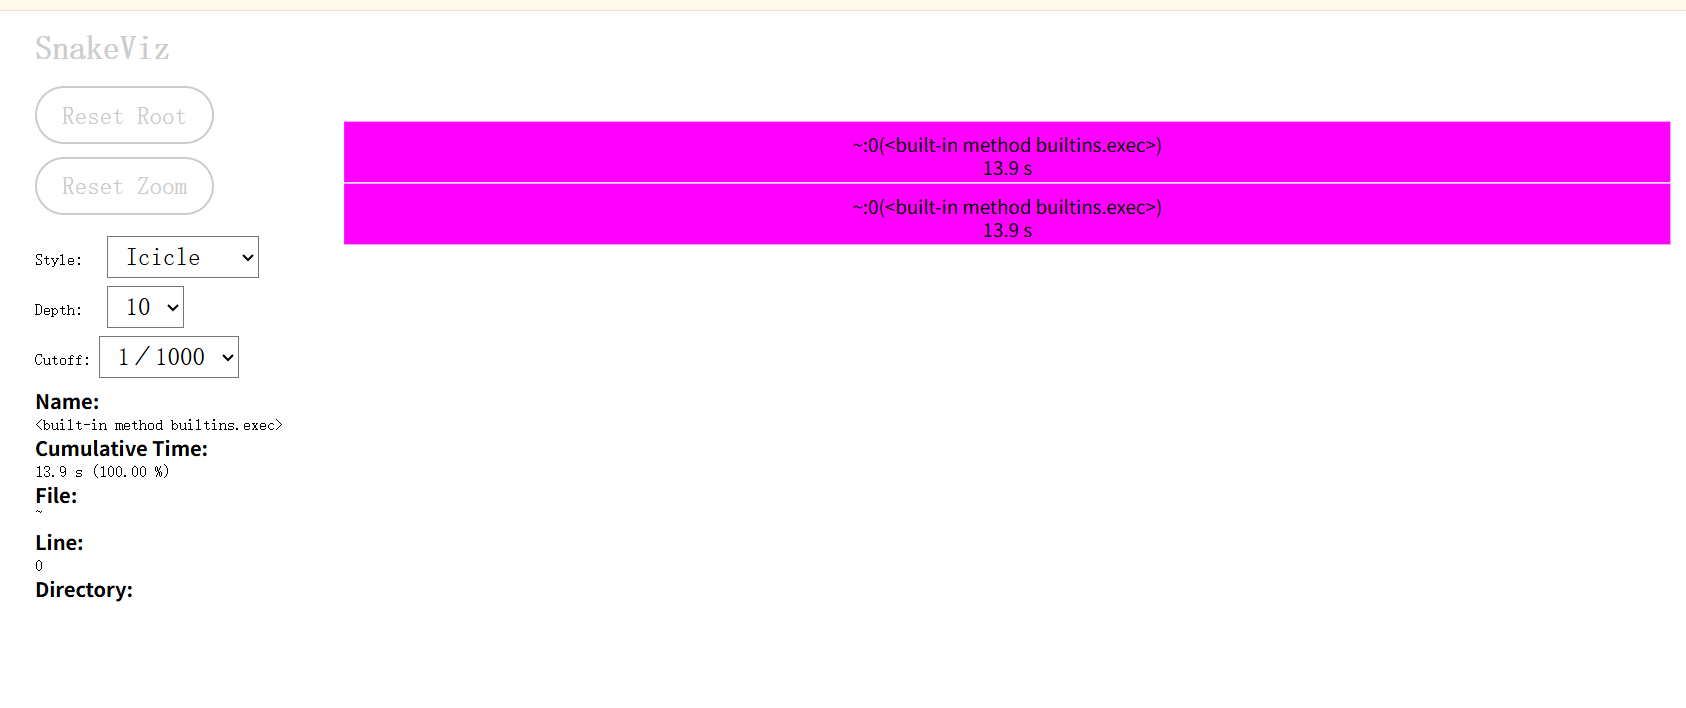

In [1]:
from IPython.display import Image

Image(filename="gpt2sampleTimer.png")

I think Snake cannot give me enough detail about how I can better see calls and instuctions running time.